# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Define size,batch,channel and epochs of images

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

# Import dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3181 files belonging to 2 classes.


# Class Name or classification attribute

In [4]:
class_names = dataset.class_names
class_names

['Normal', 'Pneumonia']

# Shape and label of 1st batch

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0]


In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[164. 164. 164.]
  [164. 164. 164.]
  [164. 164. 164.]
  ...
  [ 52.  52.  52.]
  [ 47.  47.  47.]
  [ 44.  44.  44.]]

 [[163. 163. 163.]
  [163. 163. 163.]
  [163. 163. 163.]
  ...
  [ 51.  51.  51.]
  [ 47.  47.  47.]
  [ 43.  43.  43.]]

 [[162. 162. 162.]
  [162. 162. 162.]
  [162. 162. 162.]
  ...
  [ 51.  51.  51.]
  [ 46.  46.  46.]
  [ 42.  42.  42.]]

 ...

 [[ 19.  19.  19.]
  [ 12.  12.  12.]
  [  5.   5.   5.]
  ...
  [ 18.  18.  18.]
  [ 13.  13.  13.]
  [  0.   0.   0.]]

 [[ 19.  19.  19.]
  [ 12.  12.  12.]
  [  4.   4.   4.]
  ...
  [ 18.  18.  18.]
  [ 13.  13.  13.]
  [  0.   0.   0.]]

 [[ 19.  19.  19.]
  [ 11.  11.  11.]
  [  3.   3.   3.]
  ...
  [ 18.  18.  18.]
  [ 12.  12.  12.]
  [  0.   0.   0.]]]


# Fetch or visualize the image with their respective labels

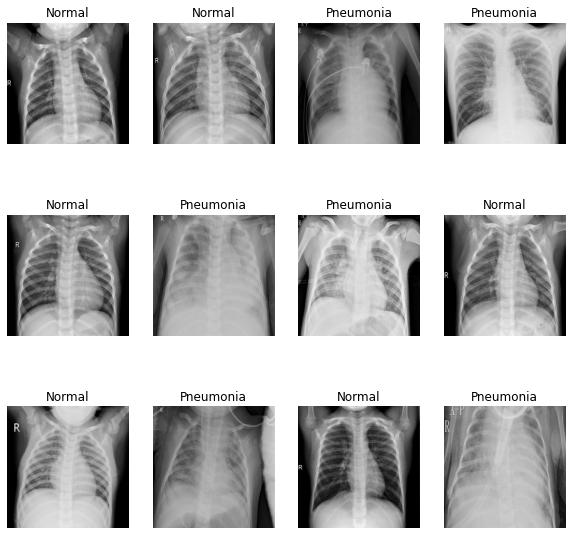

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Split data as 80 percentage for training, 10 percentage for validating and 10 percentage for testing

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Size of training dataset, testing dataset and validating dataset

In [10]:
len(train_ds)

80

In [11]:
len(val_ds)

10

In [12]:
len(test_ds)

10

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing and rescaling image

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
80/80 [==============================] - 159s 2s/step - loss: 0.6984 - accuracy: 0.5742 - val_loss: 0.6474 - val_accuracy: 0.6346
Epoch 2/30
80/80 [==============================] - 176s 2s/step - loss: 0.5188 - accuracy: 0.7584 - val_loss: 0.5474 - val_accuracy: 0.7641
Epoch 3/30
80/80 [==============================] - 180s 2s/step - loss: 0.3336 - accuracy: 0.8792 - val_loss: 0.3206 - val_accuracy: 0.8704
Epoch 4/30
80/80 [==============================] - 177s 2s/step - loss: 0.2944 - accuracy: 0.8863 - val_loss: 0.3119 - val_accuracy: 0.8904
Epoch 5/30
80/80 [==============================] - 176s 2s/step - loss: 0.2404 - accuracy: 0.9071 - val_loss: 0.1910 - val_accuracy: 0.9236
Epoch 6/30
80/80 [==============================] - 178s 2s/step - loss: 0.2322 - accuracy: 0.9079 - val_loss: 0.1770 - val_accuracy: 0.9336
Epoch 7/30
80/80 [==============================] - 177s 2s/step - loss: 0.2069 - accuracy: 0.9272 - val_loss: 0.1659 - val_accuracy: 0.9336
Epoch 8/30
80

In [20]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 8s 573ms/step - loss: 0.1877 - accuracy: 0.9500


In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

first image to predict
first image's actual label: Normal
predicted label: Normal


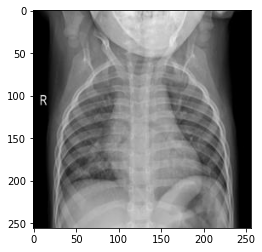

In [26]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

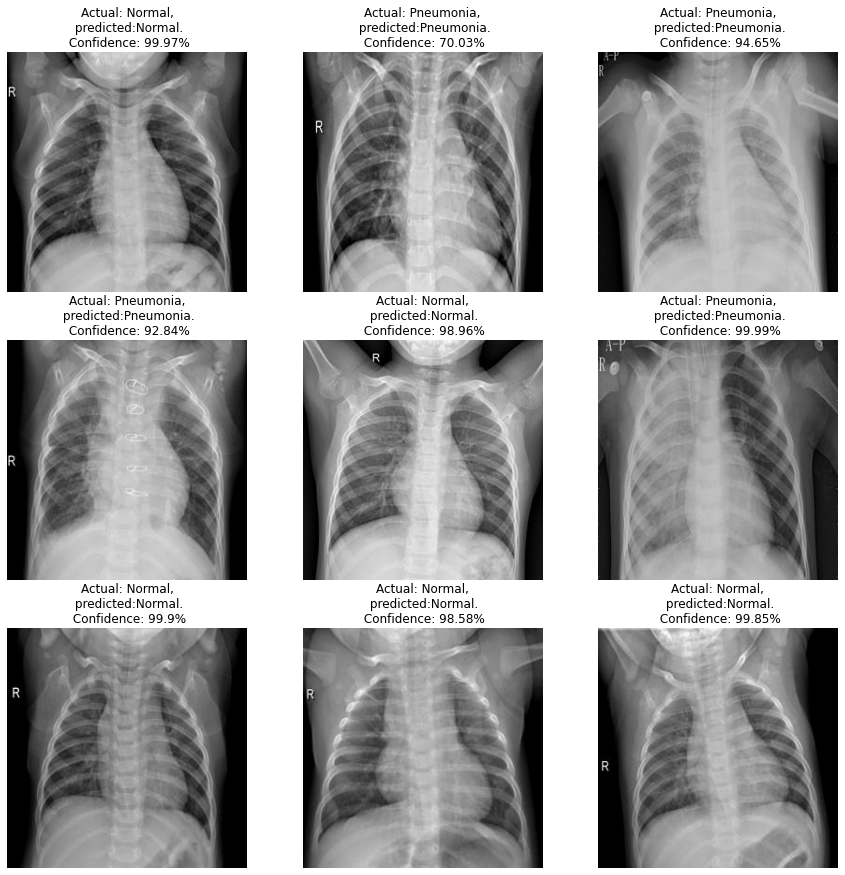

In [28]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n predicted:{predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [29]:
from PIL import Image
import numpy as np
img_path=r'C:\Users\shah9\Desktop\Diseases Prediction Using CNN\train\Pneumonia\Pneumonia1.jpeg'
im=Image.open(img_path)
img_array=tf.keras.preprocessing.image.img_to_array(im)
img_array=tf.expand_dims(img_array,0)
    
predictions=model.predict(img_array)
    
predicted_class=class_names[np.argmax(predictions[0])]
confidence=round(100*(np.max(predictions[0])),2)

In [30]:
print(predicted_class)
print(confidence)

Pneumonia
98.99


In [31]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets
